In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.colors as mcolors
import matplotlib.path as mpath
from matplotlib.ticker import MaxNLocator
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches



In [2]:
def load_trend_data(variable, model, experiment, period):
    #loads in the trend data
    #factor to convert trend data from Pa/year to hPa
    conversion_factor = 1.65
    
    #slice trend to the N. Atlantic
    lat_range = slice(20, 80)
    lon_range = slice(-90, 40)
    
    filepath = f"{base_dir}/trend_calc_LESFMIP/linear_regression/NAO/{experiment}/{model}/psl_mon_{experiment}_{model}_DJF_linear_trend_{period}_stats.nc"
    return xr.open_dataset(filepath).sel(lat=lat_range, lon=lon_range) * conversion_factor

def load_proj_or_resid_data(variable, mode, index, model, experiment, period):
    #loads in the projected or residual data
    filepath = f"{base_dir}/projection_indicies/NAtlantic_forced_trends/{experiment}/{model}/psl_mon_{experiment}_{model}_DJF_{index}_{mode}_{period}.nc"
    return xr.open_dataset(filepath)

def get_min_max(data_dict, variable):
    #finds the max and min values of the data
    values_min = [np.min(data[variable]) for data in data_dict.values()]
    values_max = [np.max(data[variable]) for data in data_dict.values()]
    return min(values_min), max(values_max)

# Define the model name and path template
model = ['CanESM5']
base_dir = '/gws/nopw/j04/extant/users/slbennie'

period = '1850-2015'
period_title = '1850-2014'

# List of forcing experiments
experiments = ['historical', 'hist-aer', 'hist-GHG', 'hist-sol', 'hist-totalO3', 'hist-volc']


for m in model:
    # Load trend data
    trend_data = {experiment: load_trend_data('psl', m, experiment, period) for experiment in experiments}
    
    # Load NAO projection and residual
    proj_data = {experiment: load_proj_or_resid_data('psl', 'projection', 'NAO', m, experiment, period) for experiment in experiments}
    residual_data = {experiment: load_proj_or_resid_data('psl', 'residual', 'NAO', m, experiment, period) for experiment in experiments}
    
    # Load EA projection and residual
    proj_data_EA = {experiment: load_proj_or_resid_data('psl', 'projection', 'EA', m, experiment, period) for experiment in experiments}
    residual_data_EA = {experiment: load_proj_or_resid_data('psl', 'residual', 'EA', m, experiment, period) for experiment in experiments}

#finding the min and max for each dataset to set a colour scheme for all of the plots
min_trend, max_trend = get_min_max(trend_data, 'slope')
min_proj, max_proj = get_min_max(proj_data, 'projection_NAO_djf')
min_resid, max_resid = get_min_max(residual_data, 'residual_NAO_djf')
min_proj_EA, max_proj_EA = get_min_max(proj_data_EA, 'projection_EA_djf')
min_resid_EA, max_resid_EA = get_min_max(residual_data_EA, 'residual_EA_djf')

# Overall min/max
min_all = min(min_trend, min_proj, min_resid, min_proj_EA, min_resid_EA)
max_all = max(max_trend, max_proj, max_resid, max_proj_EA, max_resid_EA)

# Color normalization
norm_all = mcolors.TwoSlopeNorm(vmin=min_all, vcenter=0, vmax=max_all)


In [3]:
# Order of data layers for rows
data_layers = [
    (trend_data, 'slope'),                      # Trend
    (proj_data, 'projection_NAO_djf'),          # Project onto NAO
    (residual_data, 'residual_NAO_djf'),        # Residual after NAO
    (proj_data_EA, 'projection_EA_djf'),        # Project residual onto EA
    (residual_data_EA, 'residual_EA_djf')       # Residual after EA
]

titles = ['historical','hist-aer','hist-GHG','hist-sol','hist-totalO3','hist-volc']

/tmp/ipykernel_577/2995127603.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,0.91,0.97])


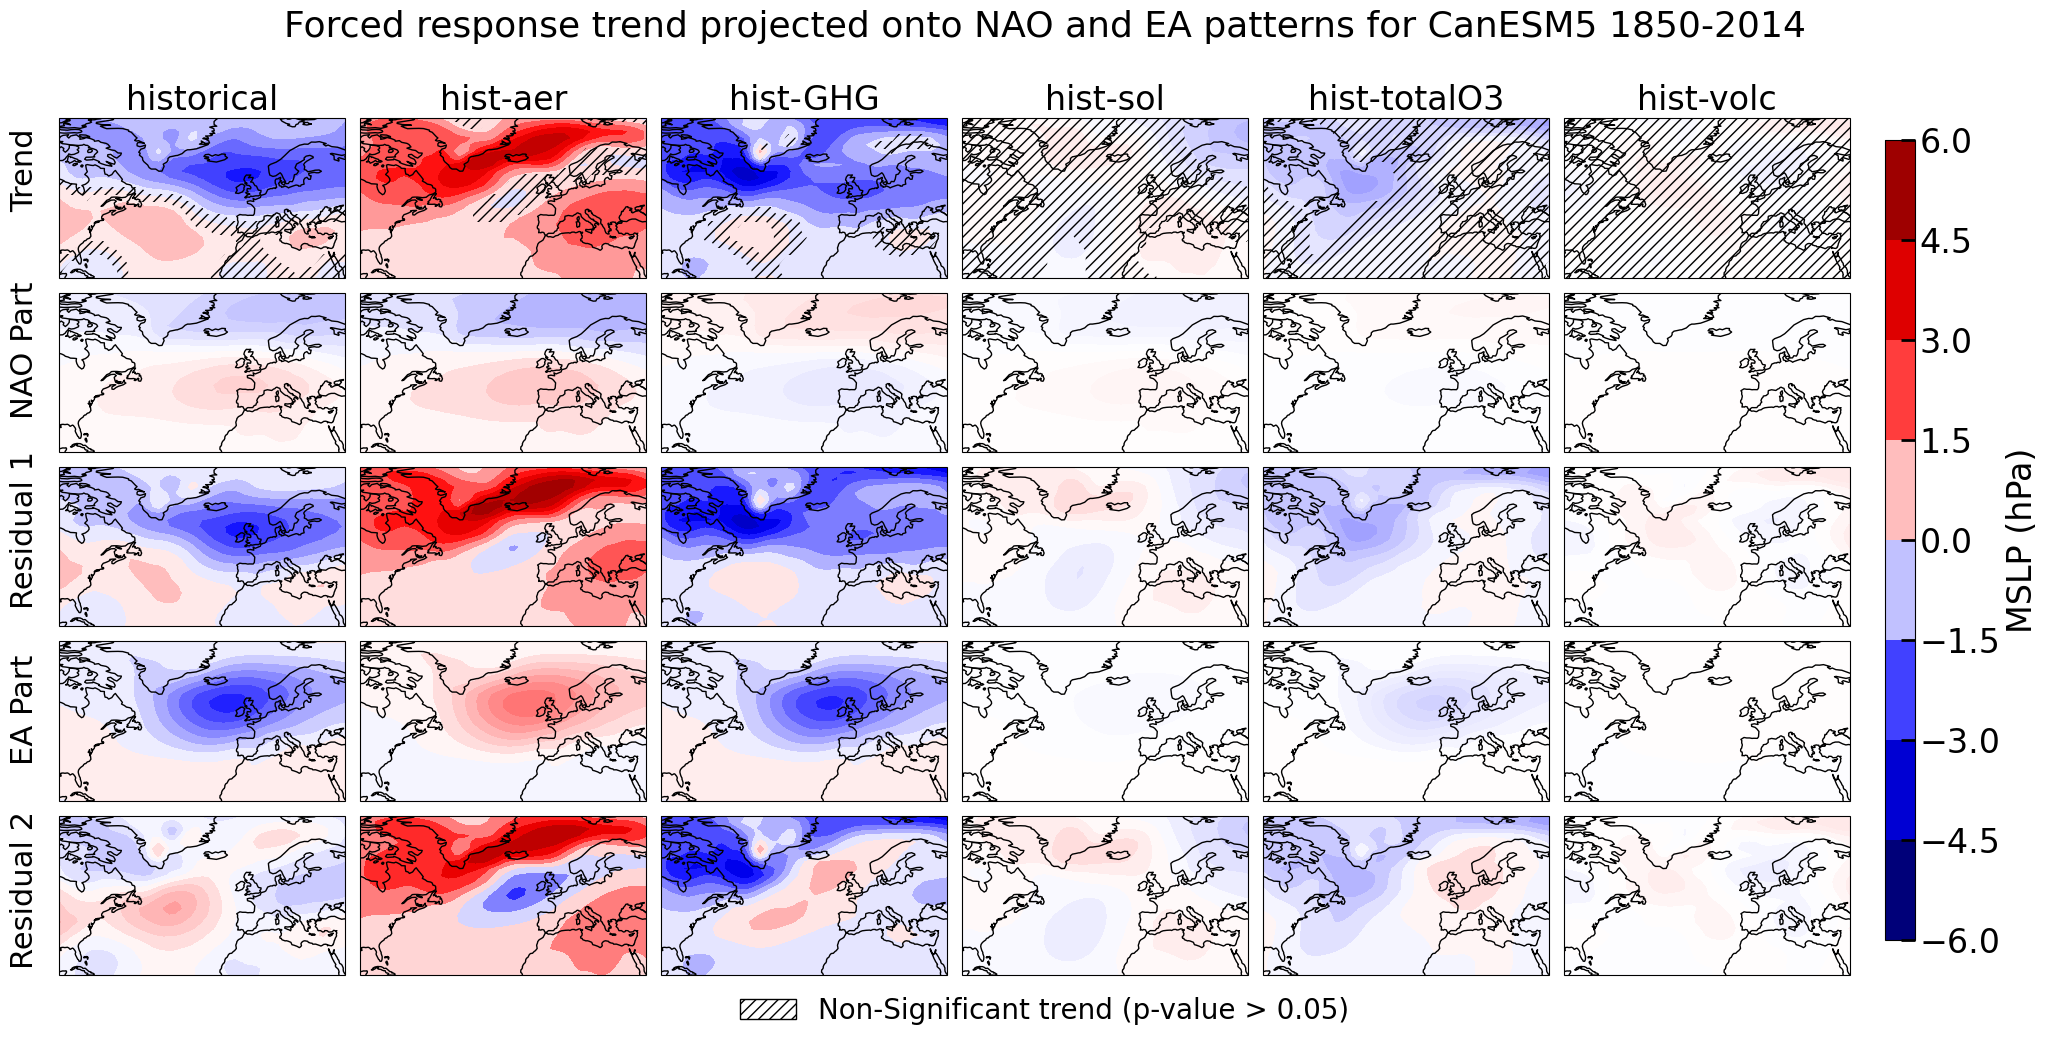

In [4]:
#PLOTTING - 5 row fig, trend, NAO part, residual 1, EA part, residual 2

fig, ax = plt.subplots(nrows=5, ncols=6, figsize=(20,10), subplot_kw={'projection': ccrs.PlateCarree()})
cmap = 'seismic'

# Dummy colorbar setup
#max_abs = np.round(max(abs(min_all), abs(max_all)),1)
#levels = np.round(np.linspace(-max_abs, max_abs, 50),1)
#dummy_data = np.array([[min_all, max_all], [min_all, max_all]])
#dummy_cont = ax[0, 0].contourf([0,1], [0,1], dummy_data, cmap=cmap, norm=norm_all)#, levels=levels)
norm_all = mcolors.Normalize(vmin=-6, vmax=6)
dummy_data = np.array([[-6,6], [-6,6]])
dummy_cont = ax[0,0].contourf([0,1], [0,1], dummy_data, cmap=cmap, norm=norm_all)


# Map extent
lon_min, lon_max = -90, 40
lat_min, lat_max = 20, 80

# Plotting each row and column
for i, (data_dict, varname) in enumerate(data_layers):
    for j, experiment in enumerate(titles):
        data = data_dict[experiment]
        ax[i, j].contourf(data['lon'], data['lat'], data[varname], cmap=cmap, norm=norm_all)#, levels=levels)
        if i == 0:
            mask = data['p_value'] > 0.05
            ax[i,j].contourf(data['lon'], data['lat'], mask, levels=[0.5,1], colors='none', hatches=['///'], transform=ccrs.PlateCarree(), alpha=0)

        if i == 0:
            ax[i, j].set_title(experiment, fontsize=24)

# Add coastlines and formatting
for i in range(5):
    for j in range(6):
        ax[i, j].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
        ax[i, j].add_feature(cfeature.COASTLINE, linewidth=1)
        ax[i, j].set_xlabel('lon', fontsize=12)
        ax[i, j].set_ylabel('lat', fontsize=12)
        ax[i, j].set_aspect('auto')

# Add colorbar
cax = fig.add_axes([0.92, 0.05, 0.015, 0.8])
cbar = fig.colorbar(dummy_cont, cax=cax)
cbar.set_label('MSLP (hPa)', fontsize=24)
cbar.ax.tick_params(direction='in', length=10, width=2, labelsize=24)
#cbar.locator = MaxNLocator(nbins=10)
#cbar.update_ticks()

# Add overall labels and title
fig.suptitle(f"Forced response trend projected onto NAO and EA patterns for {model[0]} {period_title}", fontsize=26)
row_labels = ['Trend', 'NAO Part', 'Residual 1', 'EA Part', 'Residual 2']
for i, label in enumerate(row_labels):
    fig.text(-0.01, 0.82 - i*0.18, label, rotation=90, va='center', ha='center', fontsize=22)


# Create custom legend handles for the hatches
patch1 = mpatches.Patch(facecolor='white', edgecolor='black', hatch='///', label='Non-Significant trend (p-value > 0.05)')

#fig.subplots_adjust(bottom=0.15)  # Add space at the bottom

# Add the legend below the plot
fig.legend(handles=[patch1], loc='lower center', fontsize=20, frameon=False, bbox_to_anchor=(0.5, -0.06))

plt.tight_layout(rect=[0,0,0.91,0.97])
plt.savefig(f'Figures/Forced_response_trend_proj_{model[0]}_{period_title}.png', bbox_inches='tight')
plt.show()


/tmp/ipykernel_577/2024748141.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


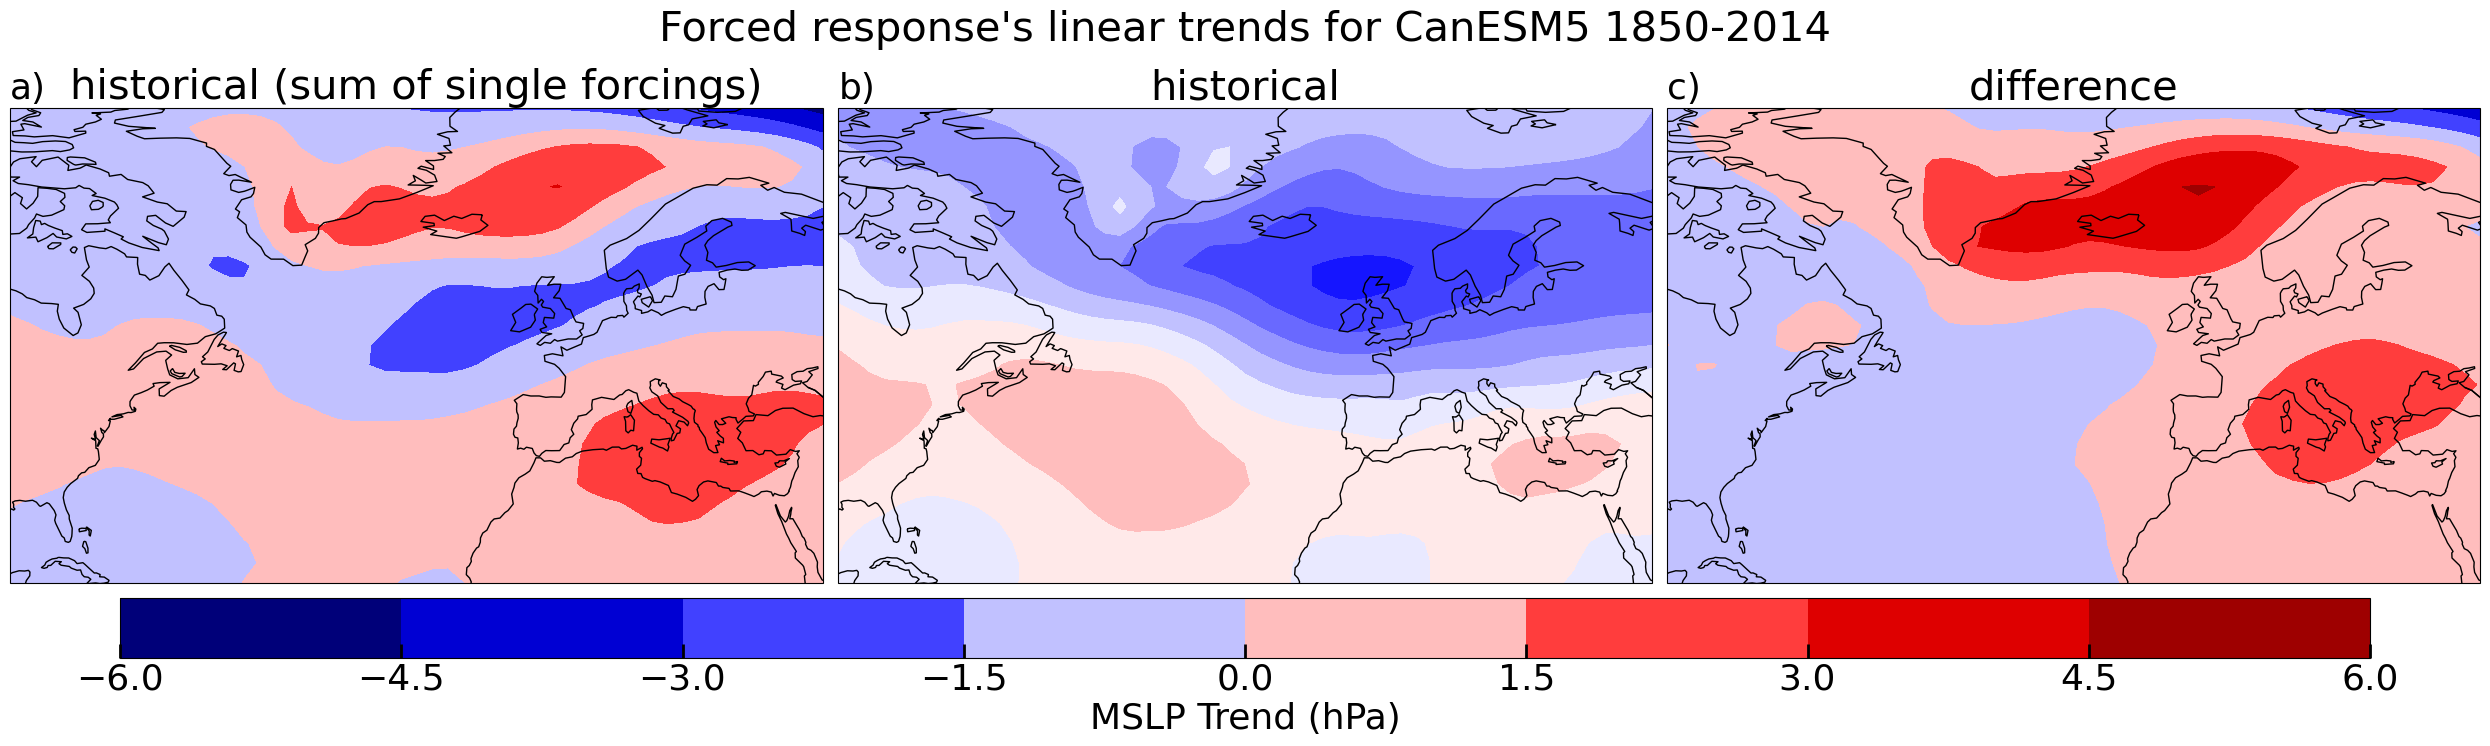

In [5]:
#PLOTTING - checking additivity

# Define the forcings
experiments = ['hist-aer', 'hist-GHG', 'hist-sol', 'hist-totalO3', 'hist-volc']

# Sum all individual forcings
historical_trend_sum = sum(trend_data[experiment] for experiment in experiments)

# Compute the difference
historical_trend_diff = historical_trend_sum - trend_data['historical']

# Set up the figure
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 6), subplot_kw={'projection': ccrs.PlateCarree()})
titles_additivity = [
    'historical (sum of single forcings)',
    'historical',
    'difference'
]
data_to_plot = [
    historical_trend_sum,
    trend_data['historical'],
    historical_trend_diff
]

# Define levels (if needed)
#levels = np.linspace(min_all, max_all, 21)

# Plot
for i in range(3):
    cont = ax[i].contourf(
        data_to_plot[i]['lon'], 
        data_to_plot[i]['lat'], 
        data_to_plot[i]['slope'], 
        cmap=cmap, norm=norm_all),# levels=levels
    #)
    ax[i].set_title(titles_additivity[i], fontsize = 30)
    ax[i].set_xlabel('lon')
    ax[i].set_ylabel('lat')
    ax[i].add_feature(cfeature.COASTLINE, linewidth=1, edgecolor='black')
    ax[i].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax[i].set_aspect('auto')

# Add colorbar (reusing dummy contour is still fine)

cax = fig.add_axes([0.05, -0.1, 0.9, 0.1])
cbar = fig.colorbar(dummy_cont, cax=cax, orientation='horizontal')
cbar.set_label('MSLP Trend (hPa)', fontsize=26)
cbar.ax.tick_params(direction='in', length=10, width=2, labelsize=26)
ax[0].set_title('a)', loc='left', fontsize=26)
ax[1].set_title('b)', loc='left', fontsize=26)
ax[2].set_title('c)', loc='left', fontsize=26)


fig.suptitle(f"Forced response's linear trends for {model[0]} {period_title}", fontsize=30)
plt.tight_layout()
plt.savefig(f'Figures/Comparing_historical_to_sum_{model[0]}_{period_title}.png', bbox_inches='tight')

CanESM5


/tmp/ipykernel_577/2354700262.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,0.91,0.97])


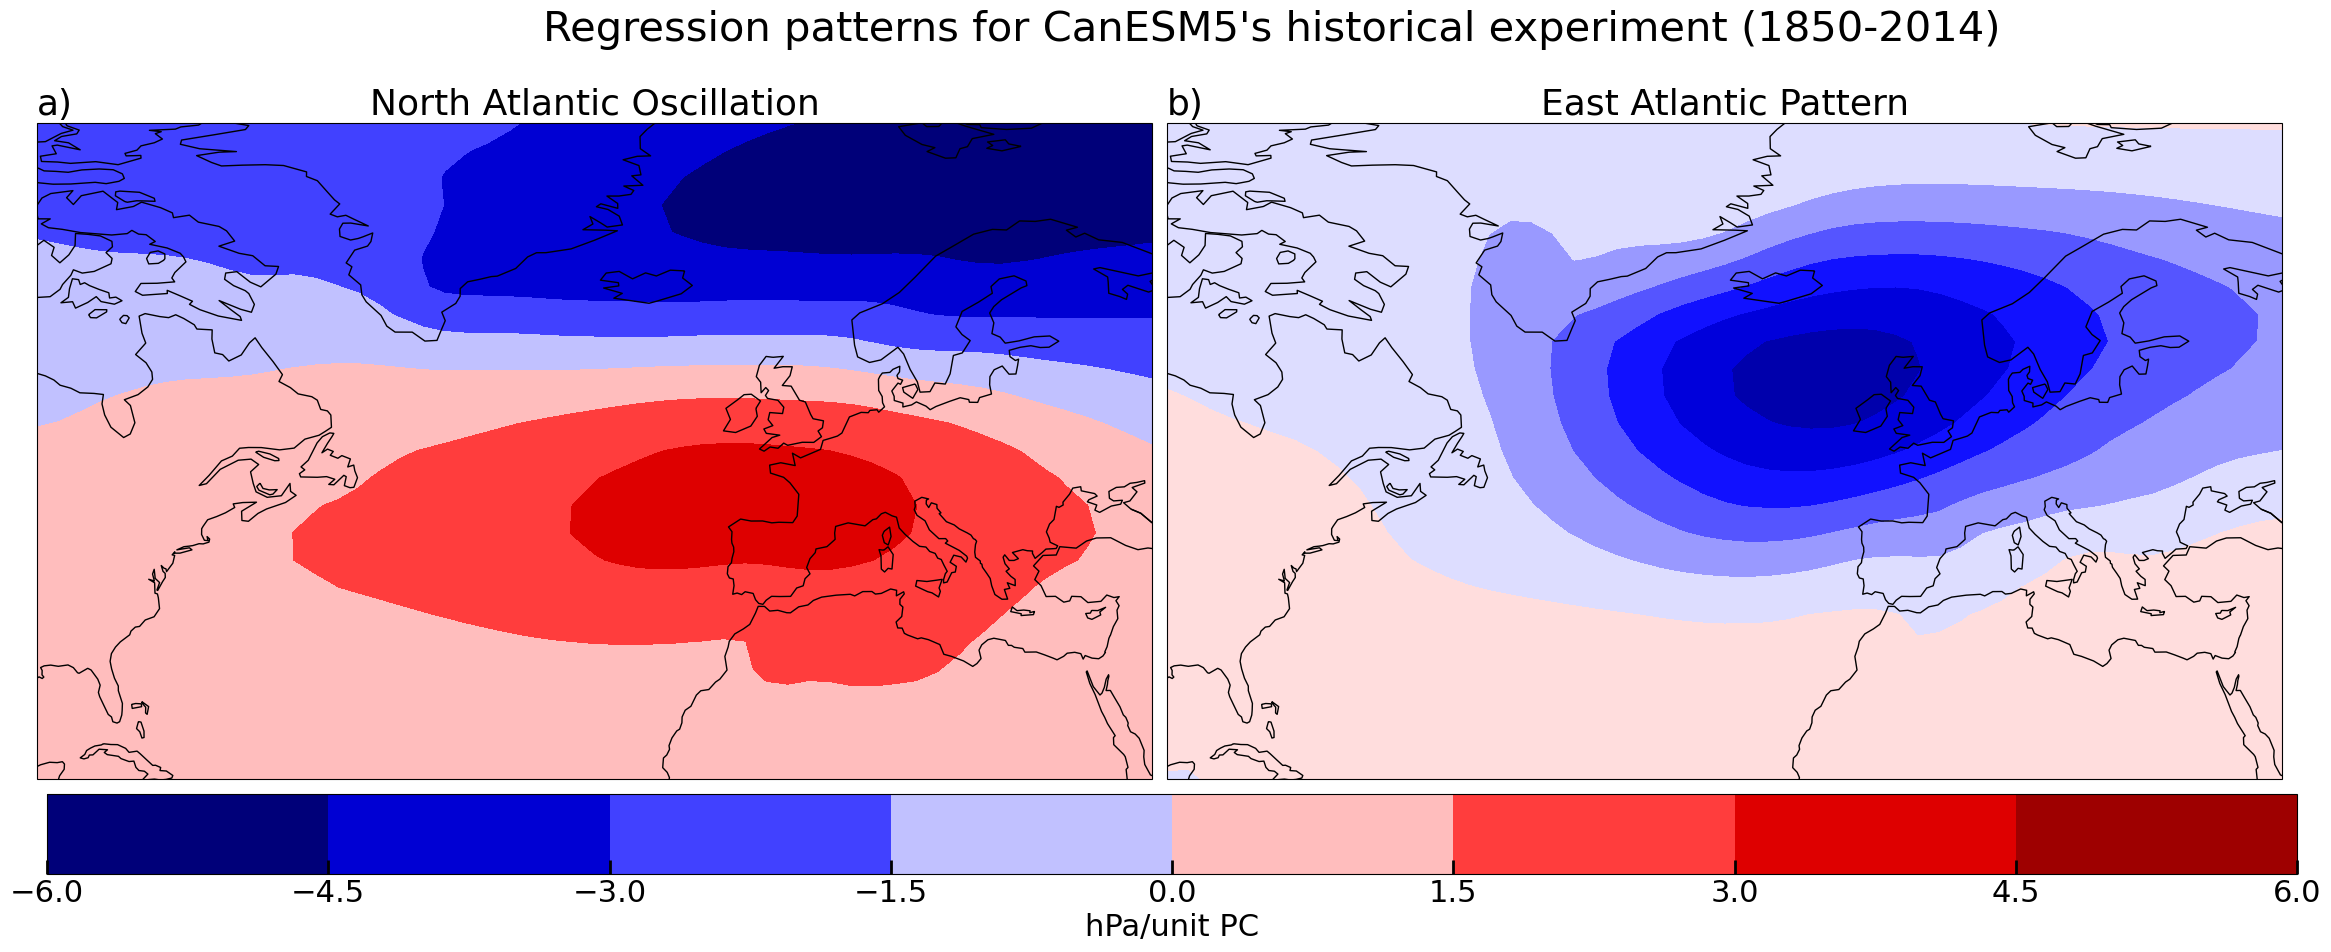

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25,8), subplot_kw={'projection': ccrs.PlateCarree()})
cmap = 'seismic'

print(model[0])
NAO_EOF = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/regression_patterns/NAO/psl_mon_historical_'+model[0]+'_DJF_NAO_regression_map_'+period+'.nc')
EA_EOF = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/regression_patterns/EA/psl_mon_historical_'+model[0]+'_DJF_EA_regression_map_'+period+'.nc')

min_NAO = np.min(NAO_EOF['regression_NAO_djf'].values)
max_NAO = np.max(NAO_EOF['regression_NAO_djf'].values)

min_EA = np.min(EA_EOF['regression_EA_djf'].values)
max_EA = np.max(EA_EOF['regression_EA_djf'].values)

min_EOF = min(min_NAO, min_EA)
max_EOF = max(max_NAO, max_EA)

lon_NAO = NAO_EOF['lon'].values
lat_NAO = NAO_EOF['lat'].values

lon_EA = EA_EOF['lon'].values
lat_EA = EA_EOF['lat'].values

#norm_EOF = mcolors.TwoSlopeNorm(vmin=min_EOF, vcenter=0, vmax=max_EOF)

#dummy_data = np.array([[min_EOF, max_EOF], [min_EOF, max_EOF]])
#dummy_cont = ax[0].contourf([0,1], [0,1], dummy_data, cmap=cmap, norm=norm_EOF)#, levels=levels)
norm_EOF = norm_all

# Map extent
lon_min, lon_max = -90, 40
lat_min, lat_max = 20, 80

# Plot
for i in range(2):
    #)
    ax[i].set_xlabel('lon')
    ax[i].set_ylabel('lat')
    ax[i].add_feature(cfeature.COASTLINE, linewidth=1, edgecolor='black')
    ax[i].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax[i].set_aspect('auto')

# Add colorbar (reusing dummy contour is still fine)

ax[0].contourf(lon_NAO, lat_NAO, (-1*NAO_EOF['regression_NAO_djf']).squeeze(), cmap=cmap, norm=norm_EOF, transform=ccrs.PlateCarree())
ax[1].contourf(lon_EA, lat_EA, EA_EOF['regression_EA_djf'].squeeze(), cmap=cmap, norm=norm_EOF, transform=ccrs.PlateCarree())

cax = fig.add_axes([0.01, -0.1, 0.9, 0.1])
cbar = fig.colorbar(dummy_cont, cax=cax, orientation='horizontal')
cbar.set_label('hPa/unit PC', fontsize=22)
cbar.ax.tick_params(direction='in', length=10, width=2, labelsize=22)
ax[0].set_title('North Atlantic Oscillation', fontsize=26)
ax[0].set_title('a)', loc='left', fontsize=26)
ax[1].set_title('East Atlantic Pattern', fontsize=26)
ax[1].set_title('b)', loc='left', fontsize=26)


# Add overall labels and title
fig.suptitle(f"Regression patterns for {model[0]}'s historical experiment ({period_title})", fontsize=30)
plt.tight_layout(rect=[0,0,0.91,0.97])
plt.savefig(f'Figures/NAO_EA_regression_patterns_{model[0]}_{period_title}.png', bbox_inches='tight')
plt.show()

/tmp/ipykernel_577/3502373637.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,0.91,0.97])


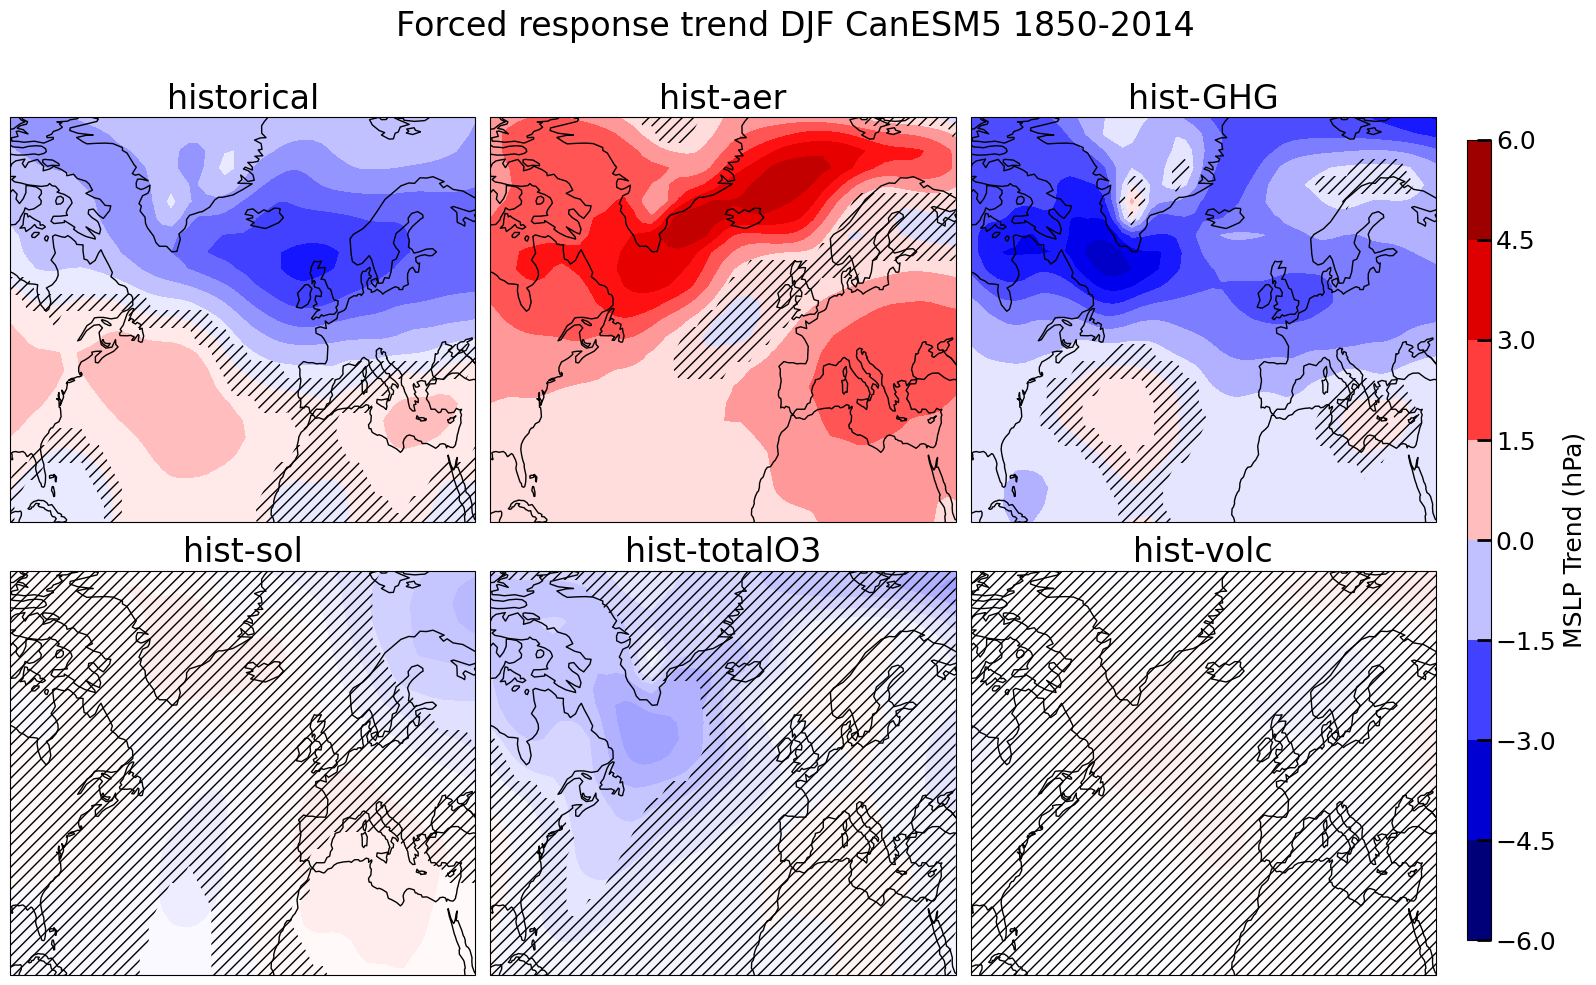

In [7]:
#PLOTTING - 5 row fig, trend, NAO part, residual 1, EA part, residual 2

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16,10), subplot_kw={'projection': ccrs.PlateCarree()})
cmap = 'seismic'
titles = ['historical','hist-aer','hist-GHG','hist-sol','hist-totalO3','hist-volc']

# Dummy colorbar setup
#max_abs = np.round(max(abs(min_all), abs(max_all)),1)
#levels = np.round(np.linspace(-max_abs, max_abs, 50),1)
#dummy_data = np.array([[min_all, max_all], [min_all, max_all]])
#dummy_cont = ax[0,0].contourf([0,1], [0,1], dummy_data, cmap=cmap, norm=norm_all)#, levels=levels)

# Map extent
lon_min, lon_max = -90, 40
lat_min, lat_max = 20, 80

# Plotting each row and column
for k in range(6):
    if k < 3:
        i = 0
        j = k
    else:
        i = 1
        j = k-3
    data = trend_data[titles[k]]
    mask = data['p_value'] > 0.05
    ax[i,j].contourf(data['lon'], data['lat'], data['slope'], cmap=cmap, norm=norm_all)#, levels=levels)
    ax[i,j].contourf(data['lon'], data['lat'], mask, levels=[0.5,1], colors='none', hatches=['///'], transform=ccrs.PlateCarree(), alpha=0)

    ax[i,j].set_title(titles[k], fontsize=24)

# Add coastlines and formatting
for i in range(2):
    for j in range(3):
        ax[i,j].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
        ax[i,j].add_feature(cfeature.COASTLINE, linewidth=1)
        ax[i,j].set_xlabel('lon', fontsize=12)
        ax[i,j].set_ylabel('lat', fontsize=12)
        ax[i,j].set_aspect('auto')

# Add colorbar
cax = fig.add_axes([0.92, 0.05, 0.015, 0.8])
cbar = fig.colorbar(dummy_cont, cax=cax)
cbar.set_label('MSLP Trend (hPa)', fontsize=18)
cbar.ax.tick_params(direction='in', length=10, width=2, labelsize=18)
#cbar.locator = MaxNLocator(nbins=10)
#cbar.update_ticks()

# Add overall labels and title
fig.suptitle(f"Forced response trend DJF {model[0]} {period_title}", fontsize=24)

plt.tight_layout(rect=[0,0,0.91,0.97])
plt.savefig(f'Figures/Forced_response_trend_{model[0]}_{period_title}.png', bbox_inches='tight')
plt.show()


/tmp/ipykernel_575/1231319152.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 0.91, 0.97])


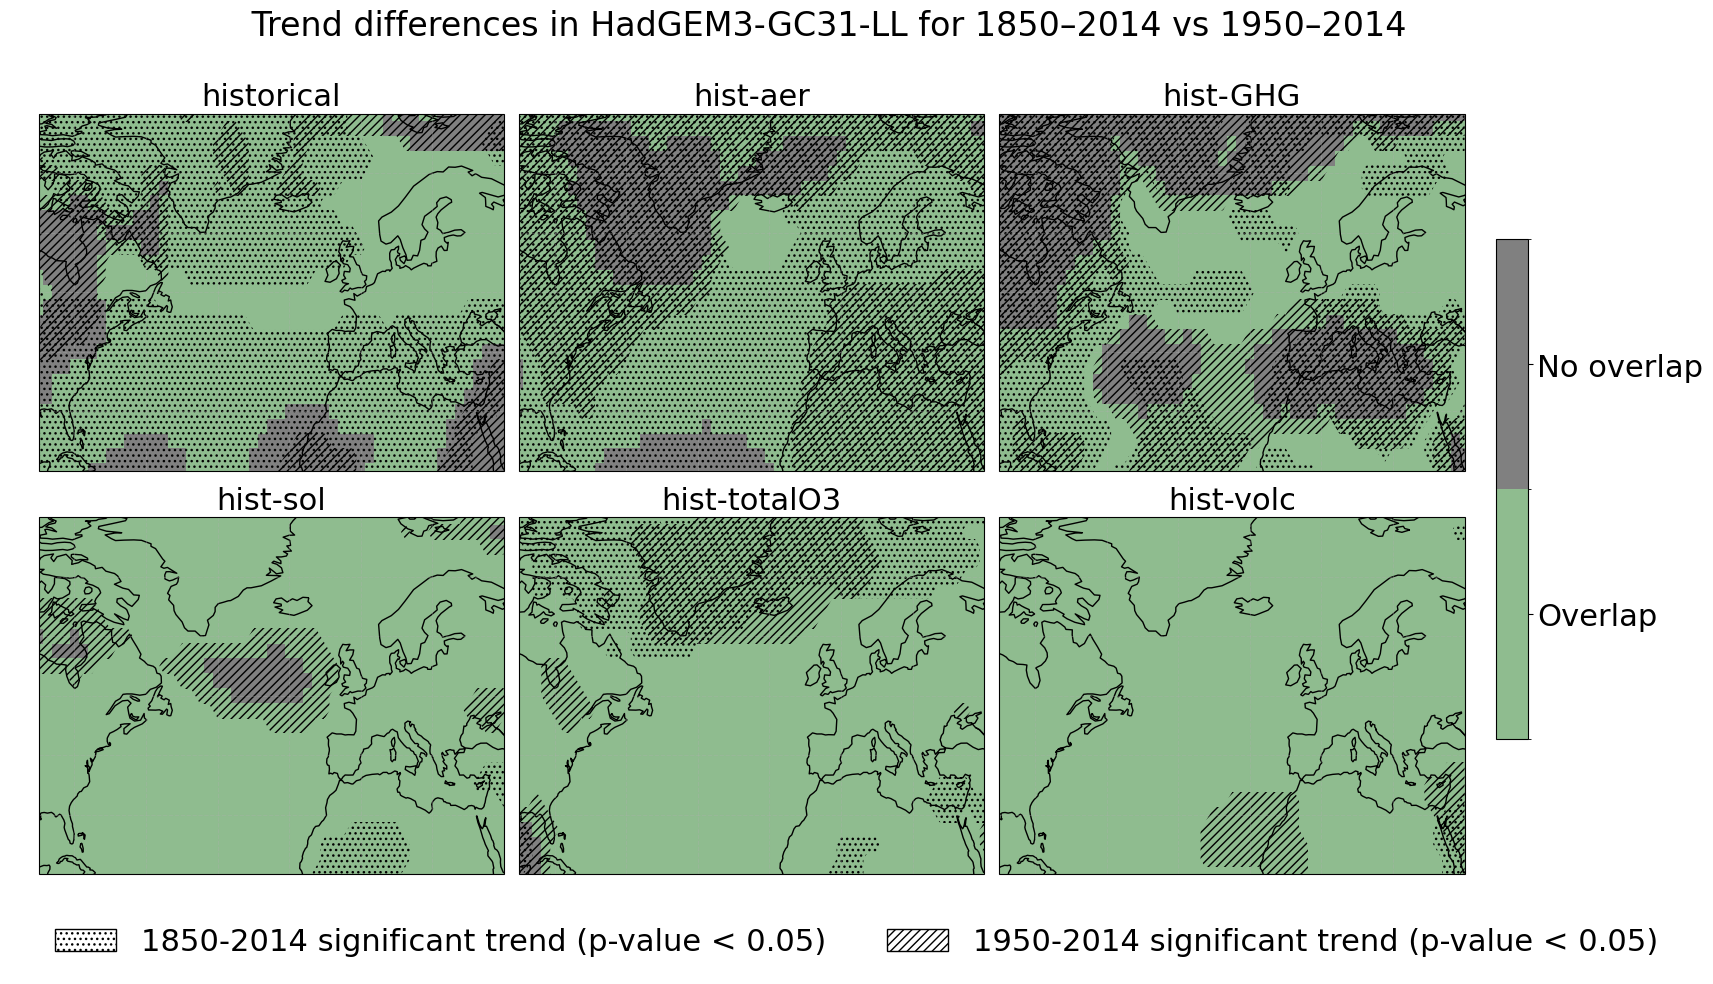

In [14]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize=(16,10), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

# Custom colors for False (overlap), True (no overlap)
cmap = mcolors.ListedColormap(['darkseagreen', 'grey'])
bounds = [0, 0.5, 1]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

lat_range = slice(20, 80)
lon_range = slice(-90, 40)

experiment = ['historical','hist-aer','hist-GHG', 'hist-sol','hist-totalO3','hist-volc']
m = 'HadGEM3-GC31-LL'

#basically can give an indes whilts going through each experiment
for i, e in enumerate(experiment):
    ds1 = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/trend_calc_LESFMIP/linear_regression/NAO/'+e+'/'+m+'/psl_mon_'+e+'_'+m+'_DJF_linear_trend_1850-2015_stats.nc').sel(lat=lat_range, lon=lon_range)
    ds2 = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/trend_calc_LESFMIP/linear_regression/NAO/'+e+'/'+m+'/psl_mon_'+e+'_'+m+'_DJF_linear_trend_1950-2015_stats.nc').sel(lat=lat_range, lon=lon_range)
    
    ci_upper1 = ds1['slope_CI_upper']
    ci_upper2 = ds2['slope_CI_upper']
    ci_lower1 = ds1['slope_CI_lower']
    ci_lower2 = ds2['slope_CI_lower']
    
    mask = (ci_upper1 < ci_lower2)|(ci_upper2 < ci_lower1)


    ax = axes[i]

    #creates a mask to find TRUE = no overlap, FALSE = overlap between the confidience intervals of the 2 trend periods
    mask.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=False)

    #creating the stipling/hatching for the significance of indiviual trends
    #basically where the trends are not zero
    #need to get some significance masks
    sig1 = ds1['p_value'] < 0.05
    sig2 = ds2['p_value'] < 0.05

    # /// diagonal hatching, xxx cross hatching
    ax.contourf(ds1['lon'], ds1['lat'], sig1, levels=[0.5,1], colors='none', hatches=['...'], transform=ccrs.PlateCarree(), alpha=0)
    ax.contourf(ds2['lon'], ds2['lat'], sig2, levels=[0.5,1], colors='none', hatches=['////'], transform=ccrs.PlateCarree(), alpha=0)
    
    ax.coastlines()
    ax.set_xlabel('lon')
    ax.set_ylabel('lat')
    ax.set_title(e, fontsize=22)
    ax.set_extent([lon_range.start, lon_range.stop, lat_range.start, lat_range.stop], crs=ccrs.PlateCarree())
    ax.gridlines(linestyle='--', alpha=0.3)
    ax.set_aspect('auto')  
    
# Create custom legend handles for the hatches
patch1 = mpatches.Patch(facecolor='white', edgecolor='black', hatch='...', label='1850-2014 significant trend (p-value < 0.05)')
patch2 = mpatches.Patch(facecolor='white', edgecolor='black', hatch='////', label='1950-2014 significant trend (p-value < 0.05)')

fig.legend(handles=[patch1, patch2], loc='lower center', ncol=2, fontsize=22, frameon=False)

# Add a shared colorbar
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax, ticks=[0.25, 0.75])
cbar.ax.set_yticklabels(['Overlap', 'No overlap'], fontsize=22)
    
plt.suptitle(" Trend differences in " + m + " for 1850–2014 vs 1950–2014", fontsize=24)
plt.savefig(f'Figures/Trend_differences_significance_{m}.png', bbox_inches='tight')
plt.tight_layout(rect=[0, 0.1, 0.91, 0.97])
plt.show()